# 2D straight crack problem under remote uniform tension - Griffith crack problem


Plane Elasticity problem 
Straight fracture in an infinite isotropic elastic medium  under uniform remote tension.

We explore the convergence as we refine the mesh for both 2DP0 and 2DP1 elements.

In [1]:
# imports etc.
import sys
import os

from bigwham4py import BEMatrix
import numpy as np
from scipy.sparse.linalg import gmres

sys.path.append(os.path.join(os.getcwd(), '../..'))
from solutions.griffith_crack import width_griffith
import matplotlib.pyplot as plt


We set the elastic properties of the medium. Note that bigwham's input are the Young's modulus $E$ and Poisson's ratio $\nu$.

In [2]:
G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)

We define a function in order to solve the problem with a given number of elements. Either for P0 elements (constant displacement interpolation) or P1 elements (linear interpolation over the element but discontinuous between element).

In [3]:
def solveGriffith(nelts,a=1,kernel = "2DP0-H"):
    """Wrapper function to solve the Griffith problem with a given number of elements + element type"""
    coor1D = np.linspace(-a, a, nelts + 1)
    coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
    conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)
    # H-matrix parameters - choosen here to have an accurate solution
    max_leaf_size=100
    eta=2.
    eps_aca=1.e-5
    elas_prop = np.array([E, nu])
    h = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)
    t = np.ones(h.shape[0])
    t[0::2] = 0.
    jac_ilu= h.H_ILU_prec() # we use a ILU decomposition of the full block for efficient solution via gmres
    d = gmres(h, t,M=jac_ilu,rtol=1e-6)[0]
    dd = d.reshape((-1, 2))
    col_pts = h.getMeshCollocationPoints()
    x_coor_=col_pts[:,0]
    # Crack opening displacement discontinuity from analytical solution 
    # note that 2DP1 segment have their solution at nodes.... 
    # note that 2DP1 segment have displacement disconinuity at element vertex for each element
    if (kernel =="2DP1-H"):
        x_coor_ = np.ones(2*nelts)
        for e in range(nelts):
            x_coor_[e*2:e*2+2]=coor1D[conn[e]]
    w_true=width_griffith(x_coor_,a=1,sig=1,G=1,nu=0.25)
    rmse = np.sqrt((np.sum(dd[:,1]-w_true)**2)/(w_true.size))
    l2rel = (np.linalg.norm((dd[:,1]-w_true)))/(np.linalg.norm(w_true))
    return x_coor_,dd,w_true,rmse,l2rel 

## Piece-wise constant interpolation element

Let's first look at the solution for P0 element, using 30 elements. We see that the numerical solution estimate of the fracture width is sligthly larger than the true solution. This is typical for this type of boundary element (see Crouch & Starfield - chapter 5).

NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  3e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.00192
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-05, eta = 2
Hierarchical matrix  construction time = :  0.001945
--------------------
0.03398146190435516


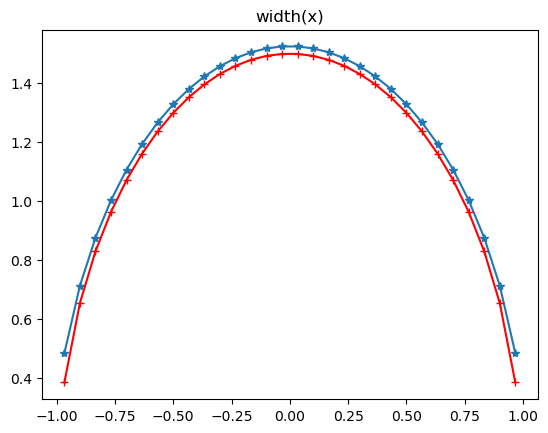

In [4]:
xcorr,dd_sol,w_true,rmse,l2rel = solveGriffith(30,a=1,kernel="2DP0-H")

plt.plot(xcorr, dd_sol[:,1], "-*")
plt.plot(xcorr, w_true, "-+r") 
plt.title('width(x)')
print(l2rel)

Now, let's perform the same numerical simulation for different number of elements. We go from 10 elements to 10'000. We compute the "approximate" rate of convergence of both the rmse and l2 relative error.
Note that the RMSE and relative L2 norm are defined respetively as
 $$rmse = \sqrt{\sum_{i=1,N} (num_i - true_i)^2/N} $$
 and
 $$L_{2 rel} = \frac{\||  \mathbf{num} - \mathbf{true} \||_2}{\|| \mathbf{true} \||_2}$$
  such that the rate of convergence of the rmse is about 1/2 of the one of the relative L2 norm.

To esitmate the rate of convernce of an error metric $e$, we compute:
$$ \beta = \log{(e_2/e_1)}/\log{(N_1/N_2)} $$

where $e_1$ is the error for $N_1$ unknowns, respectively for $e_2$ (with $N_2<N_1$). 

In [5]:
list_nelts_P0=np.array([10,20,50,100,200,500,1000,2000,5000,10000])
rmse_P0 =[]
l2_rel_P0 = []
for n in list_nelts_P0:
    col_pts,dd_sol,wtr,rmse_n,lerel_n = solveGriffith(n,a=1,kernel="2DP0-H")
    rmse_P0.append(rmse_n)
    l2_rel_P0.append(lerel_n)
    
# computing the rate of convergence
beta_rmse_P0 = [1 * np.log(rmse_P0[i]/rmse_P0[i-1])/np.log(list_nelts_P0[i-1]/list_nelts_P0[i]) for i in range(2,list_nelts_P0.size-1)]
beta_l2_P0 = [1 * np.log(l2_rel_P0[i]/l2_rel_P0[i-1])/np.log(list_nelts_P0[i-1]/list_nelts_P0[i]) for i in range(2,list_nelts_P0.size-1)]

NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  0
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.000418
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-05, eta = 2
Hierarchical matrix  construction time = :  0.000433
--------------------
NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP0-H with properties size 2
-----

0.49105270715911875


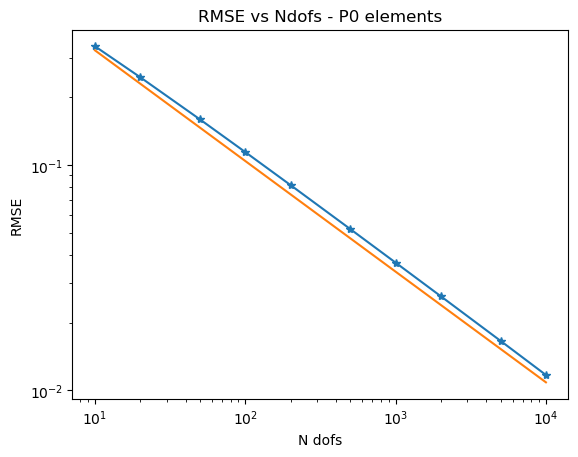

In [6]:
plt.loglog(list_nelts_P0, rmse_P0, "-*")
plt.loglog(list_nelts_P0, 1/list_nelts_P0**np.median(beta_rmse_P0), "-")
plt.title('RMSE vs Ndofs - P0 elements')
plt.xlabel('N dofs')
plt.ylabel('RMSE')
print(np.median(beta_rmse_P0))
# rmese defined as  sqrt(1/Nelts Sum  (num_i-true_i)^2)

0.9366792920461718


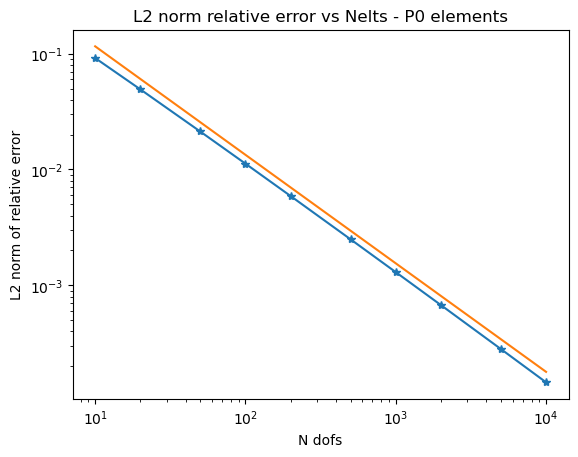

In [7]:
plt.loglog(list_nelts_P0, l2_rel_P0, "-*")
plt.loglog(list_nelts_P0, 1/list_nelts_P0**np.median(beta_l2_P0), "-")
plt.title('L2 norm relative error vs Nelts - P0 elements')
plt.xlabel('N dofs')
plt.ylabel('L2 norm of relative error')
# L2 norm relative defined as ||num_i - true_i||_2 / ||true_i||
print(np.median(beta_l2_P0))


## Piece-wise linear element

We now move to the case of piece-wise element. First, we perform a simulation with N=10 elements such that we can 'compare' with the solution obtained with 20 P0 elements. Because it's fast we recompute here the P0 solution too. Except at the tip, the solution with P1 elements is much more accurate than the P0 element for the same number of degree of freedoms !

NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.000883
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-05, eta = 2
Hierarchical matrix  construction time = :  0.000902
--------------------
NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP1-H with properties size 2
-

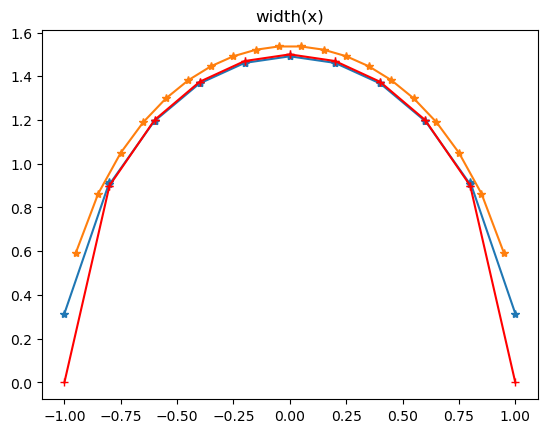

In [8]:
x_corr_P0,dd_sol_P0,w_true_P0,rmse_P0_e,l2rel_P0_e = solveGriffith(20,a=1,kernel="2DP0-H")
x_corr_P1,dd_sol_P1,w_true_P1,rmse_P1_e,l2rel_P1_e = solveGriffith(10,a=1,kernel="2DP1-H")

plt.plot(x_corr_P1, dd_sol_P1[:,1], "-*")
plt.plot(x_corr_P0, dd_sol_P0[:,1], "-*")
plt.plot(x_corr_P1, w_true_P1, "-+r") 
plt.title('width(x)')

print(rmse_P0_e)
print(rmse_P1_e)

We now turn to explore the convergence rate for P1 elements. Keep in mind that here the number of dof is twice the number of elements !

In [9]:
list_nelts_P1_aux=(list_nelts_P0/2)

list_nelts_P1=list_nelts_P1_aux.astype(int)
#np.array([10,20,50,100,200,500,1000,2000,5000,10000])
rmse_P1 =[]
l2_rel_P1 = []
for n in list_nelts_P1:
    col_pts,dd_sol,wtr,rmse_n,lerel_n = solveGriffith(n,a=1,kernel="2DP1-H")
    rmse_P1.append(rmse_n)
    l2_rel_P1.append(lerel_n)
    
# computing the rate of convergence
beta_rmse_P1 = [1 * np.log(rmse_P1[i]/rmse_P1[i-1])/np.log(list_nelts_P1[i-1]/list_nelts_P1[i]) for i in range(2,list_nelts_P1.size-1)]
beta_l2_P1 = [1 * np.log(l2_rel_P1[i]/l2_rel_P1[i-1])/np.log(list_nelts_P1[i-1]/list_nelts_P1[i]) for i in range(2,list_nelts_P1.size-1)]

NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP1-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.000361
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-05, eta = 2
Hierarchical matrix  construction time = :  0.000377
--------------------
NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP1-H with properties size 2
-

the convergence on the RMSE is smaller than for P0 -  exhibiting an  drop early on (so we exclude the first few points for the estimate of the convergence rate). Note however, than the values are lower than the P0 for the same number of dofs.

In [10]:
rmse_P0

[0.3365028222892256,
 0.2452869073291363,
 0.15932122178940974,
 0.11416135374784454,
 0.08147863607641975,
 0.05195582339538116,
 0.036888260244515074,
 0.026155870540495108,
 0.016573152701478203,
 0.01170305585081366]

0.2602213300641325


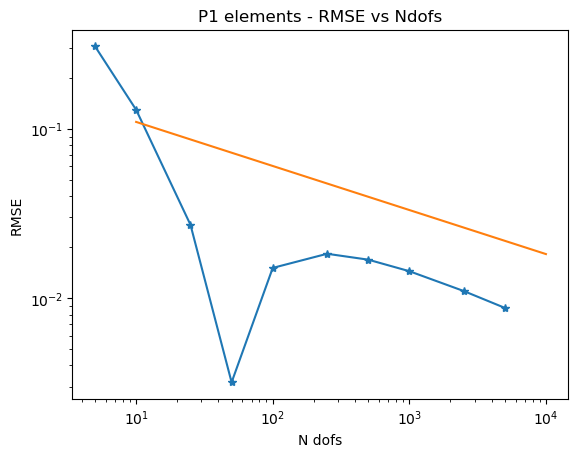

In [11]:
plt.loglog(list_nelts_P1,rmse_P1, "-*")
plt.loglog(2*list_nelts_P1, 0.2/(2*list_nelts_P1)**np.median(beta_rmse_P1[5::]), "-")
plt.title('P1 elements - RMSE vs Ndofs')
plt.xlabel('N dofs')
plt.ylabel('RMSE')
print(np.median(beta_rmse_P1[5::]))

The convergence of the L2 norm is "cleaner" and exhibit the same rate than for P0 element. However, again, the error is consistently smaller for the same number of dofs.

0.9856123657261437


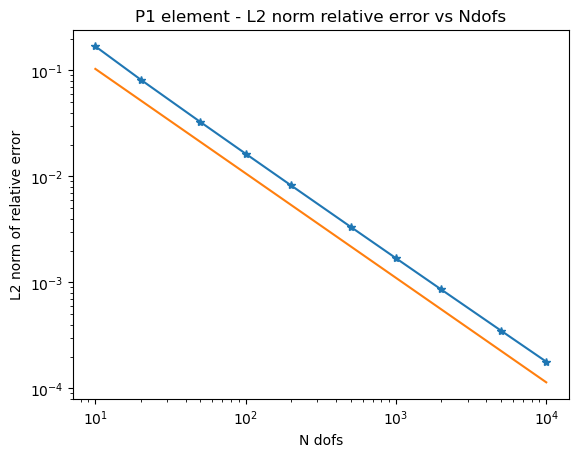

In [12]:
plt.loglog(list_nelts_P0, l2_rel_P1, "-*")
plt.loglog(list_nelts_P0, 1/list_nelts_P0**np.median(beta_l2_P1), "-")
plt.title('P1 element - L2 norm relative error vs Ndofs')
plt.xlabel('N dofs')
plt.ylabel('L2 norm of relative error')
# L2 norm relative defined as ||num_i - true_i||_2 / ||true_i||
print(np.median(beta_l2_P1))

We now compare on the same plot the convergence of the P0 and P1 elements... of course as function of the number of degree of freedoms (number of unknowns).

Text(0, 0.5, 'L2 norm of relative error')

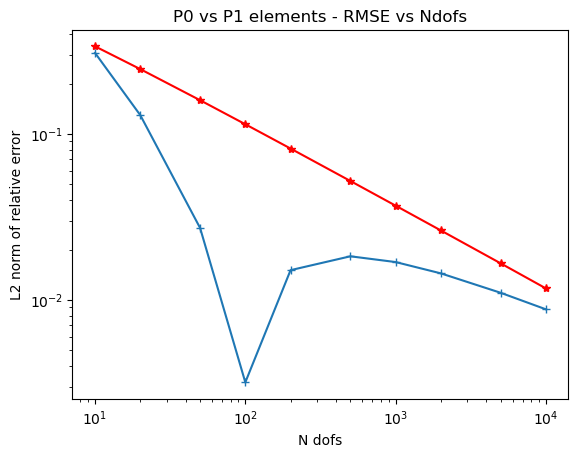

In [13]:
plt.loglog(list_nelts_P0,rmse_P0, "-*r")
plt.loglog(list_nelts_P0,rmse_P1, "-+")
#
#plt.loglog(list_nelts_P0, 1/list_nelts_P0**np.median(beta_l2_P1), "-")
plt.title('P0 vs P1 elements - RMSE vs Ndofs')
plt.xlabel('N dofs')
plt.ylabel('L2 norm of relative error')

Text(0, 0.5, 'RMSE')

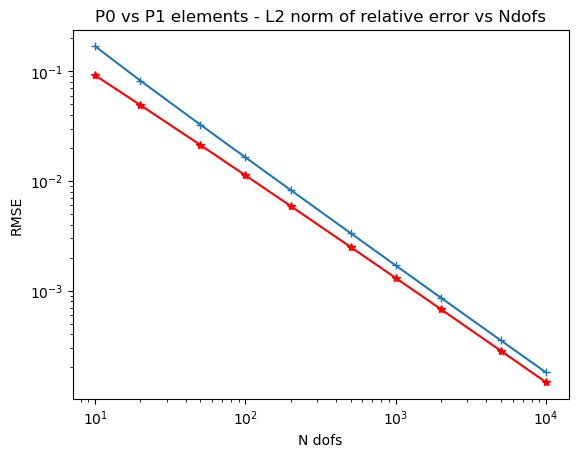

In [14]:
plt.loglog(list_nelts_P0, l2_rel_P0, "-*r")
plt.loglog(list_nelts_P0, l2_rel_P1, "-+")
#
#plt.loglog(list_nelts_P0, 1/list_nelts_P0**np.median(beta_l2_P1), "-")
plt.title('P0 vs P1 elements - L2 norm of relative error vs Ndofs')
plt.xlabel('N dofs')
plt.ylabel('RMSE')